In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# In-depth tutorial: single cycle
This tutorial/example aims to go a bit more in-depth into the code-base compared to the "Hello World" example, and discuss the major classes and functions, and how they relate to one another. The outcome is the implementation of a single update loop.

## Muon generation
The `tomopt.muon` contains functions and classes to deal with the generation and handling of muons.

`tomopt.muon.generation.MuonGenerator2016` will generate N muons on demand via random sampling. These are stored as an (N,5) tensor, with columns corresponding to (x,y,momentum,$\theta_x$,$\theta_y$), where $\theta$ is the angle between the z-axis and the trajectory of the muon in x & y. 
Currently x & y are uniform in the specified ranges, momentum and the $\theta$ are sampled from cosmic muon distribution at sea level [(arXiv:1606.06907)](https://arxiv.org/abs/1606.06907). Additionally, the momenta can be fixed to a specified value. Currently a value of 5GeV is recommended.

In [2]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [3]:
gen = MuonGenerator(x_range=(0.0,1.0), y_range=(0.0,1.0), fixed_mom=5)
gen

Muon generator: x,y range: (0.0, 1.0), (0.0, 1.0). Momentum is fixed at 5 GeV

Muons can be generated by calling the `MuonGenerator.generate_set` function, for convenience this is linked to the class' `__call__` method:

In [4]:
gen.generate_set(10), gen(10)

(tensor([[0.8798, 0.4342, 5.0000, 0.1060, 0.0312],
         [0.5498, 0.7849, 5.0000, 1.0878, 3.8216],
         [0.0312, 0.0275, 5.0000, 0.0746, 3.1711],
         [0.5281, 0.5973, 5.0000, 0.7186, 3.4025],
         [0.7023, 0.8420, 5.0000, 0.7343, 1.9545],
         [0.7498, 0.4015, 5.0000, 0.3416, 2.4621],
         [0.9216, 0.6172, 5.0000, 0.9071, 1.8648],
         [0.3069, 0.2232, 5.0000, 0.0746, 3.8186],
         [0.1925, 0.9687, 5.0000, 1.0014, 1.4074],
         [0.2481, 0.1423, 5.0000, 0.5851, 2.8111]]),
 tensor([[0.2457, 0.9266, 5.0000, 0.3024, 5.4405],
         [0.0731, 0.0148, 5.0000, 0.5301, 4.2903],
         [0.3476, 0.2439, 5.0000, 0.0589, 6.2518],
         [0.7682, 0.0207, 5.0000, 0.0275, 2.6749],
         [0.2200, 0.1335, 5.0000, 0.6715, 6.2823],
         [0.7762, 0.9107, 5.0000, 0.8050, 0.9443],
         [0.0109, 0.8225, 5.0000, 0.4673, 3.8214],
         [0.9335, 0.1109, 5.0000, 0.4987, 5.6800],
         [0.8971, 0.5548, 5.0000, 0.3495, 3.1651],
         [0.7745, 0.6733, 5.0

To provide a more convenient interface, `tomopt.muon.muon_batch.MuonBatch` is used to wrap the generated muons with methods, and property getters and setters. When instantiating a `MuonBatch`, we also need to tell it where the muons start in z. Propagation of the muons proceeds in steps of $\delta z$ in the negative z direction.

In [5]:
from tomopt.muon import MuonBatch

In [6]:
muons = MuonBatch(gen(1000), init_z=1)
muons

Batch of 1000 muons

In [7]:
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.0615), muons.y[0]=tensor(0.5043), muons.z[0]=tensor(1.), muons.theta[0]=tensor(0.2003)'

In [8]:
muons.propagate(dz=0.1)

In [9]:
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.0433), muons.y[0]=tensor(0.4953), muons.z[0]=tensor(0.9000), muons.theta[0]=tensor(0.2003)'

Normally, though, we let the volume layers (see next section) call the `propagate` method. As the muons pass through passive material and scatter the $\theta$ values of the muons will also change (along with x & y). Detector layers will append hits with reconstructed x & y to the `MuonBatch.hits` attribute, by calling `MuonBatch.append_hits`. After traversing the entire volume, the hits can be extracted using `MuonBatch.get_hits`.

## Volume definition

### Passive volume definition
First let's set up the volume; a block occupying (x,y,z) space from (0,0,0)->(L,W,H).

The `tomopt.volume` contains methods and classes to enable the definition of the active and passive volumes, the latter of which are subdivided into cubic voxels of width *size*. Each voxel can be specified as a different material with varying x0 (radiation length [m]). `tomopt.core.X0` includes a dictionary of the x0 in various materials.. Construction of a passive volume is done layer-wise in the z-axis, and each layer should be a `tomopt.volume.layer.PassiveLayer`. These are initialised by stating the z-position of the **top** of the layer, the transverse length and width of layer, and the size of each voxel (simultaneously defines the depth of the layer and the number of voxels in the layer). The user should ensure that the length and width are both divisible by the size. The materials of the voxels in the layer are defined using a function which takes the coordinates of the layer and returns an (N,M) tensor with the X0 of material for the (NxM voxels in x,y).

Current limitations:
- The scattering model used highly simplified.
- The computation of the number of radition lengths in a $\delta z$ step is based solely on the material of the voxel at the start of the step.

Below, we'll look at how to construct a passive layer

In [10]:
import torch
from torch import Tensor

In [11]:
from tomopt.core import X0

The function below takes the layer coordinates and returns a tensor with voxel material for the layer at the specified z, In this case, it will return beryllium for all voxels, except for the layer at z=0.4, which will contain a block of lead for x_voxels > 5 and y_voxels > 5. Note that the function takes absolute coordinates in metres and must manually convert to voxel-coordinates using the size.

In [12]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [13]:
from tomopt.volume import PassiveLayer

In [14]:
pl = PassiveLayer(rad_length_func=arb_rad_length, lw=Tensor([1,1]), z=0.2, size=0.1)

The `PassiveLayer` inherits from `tomopt.volume.layer.Layer`, which in turn inherits from `torch.nn.Module`, and passing a `MuonBatch` through a `Layer` involves calling its `forward` method (or calling the object, since `nn.Module.__call__` points to `forward`).

When a `MuonBatch` is passed through the `PassiveLayer`, it does so in `n` steps of $\delta z$, and at each step undergoes multiple scattering according the material traversed. Note that the `forward` method does not return the propagated `MuonBatch`, but instead updates the internal parameters of the `MuonBatch` in-place.

In [15]:
muons = MuonBatch(gen(1000), init_z=0.2)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.8217), muons.y[0]=tensor(0.4952), muons.z[0]=tensor(0.2000), muons.theta[0]=tensor(0.4516)'

In [16]:
pl(mu=muons, n=2)

In [17]:
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.8700), muons.y[0]=tensor(0.4908), muons.z[0]=tensor(0.1000), muons.theta[0]=tensor(0.4516)'

Note that the muons have dropped to the bottom of the passive layer, and that their $\theta$ values have also changed due to the multiple-scattering. Multiple scattering can also cause shifts in x and y.

### Detector layer definition

Detector layers form regions of space above and below the passive volume and contain a fixed number panels, each of which spans a varying $xy$ area, is centred at a vaying $x,y,z$ coordinate, and has a fixed resolution and efficiency. The position and span of the panels are parameters to be optimised. The *cost* of each panel depends on its area and by including the cost in the loss function, the optimisation is prevented from simply maxing out the detector parameters.

Current limitations:
- Planels are infinitely thin and do **not** scatter muons.

Again `tomopt.volume.layer.PanelDetectorLayer` is initialised using the z-position of the **top** of the layer, the transverse length and width of layer, and the size heigh in $z$. `pos` is used to indicate if the layer is above or below the passive volume. The `panels` argument takes a `nn.ModuleList` of `tomopt.volume.panel.DetectorPanel` objects, which must be initialised with a resolution, efficiency, $x,y,z$ position, $xy$ span, and cost function to determine the cost of the panel from its area.

Below is an arbitrary cost function:

In [18]:
import matplotlib.pyplot as plt

import torch.nn.functional as F

<ipython-input-19-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


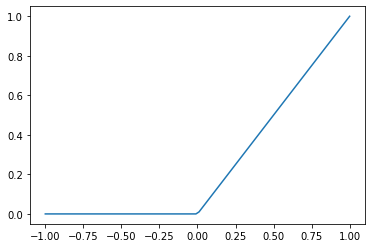

In [19]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

#### Detector Panel

Let's create a detetcor panel

In [20]:
from tomopt.volume import DetectorPanel

In [21]:
panel = DetectorPanel(res=1e3, eff=0.5, init_xyz=[0.5,0.5,0.9], init_xy_span=[0.5,0.5], area_cost_func=area_cost)
panel

<class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])

Unlike `Layer` classes, we don't call the forward method of `DetectorPanel`, instead we must manually propagate the muons to the z-position of the panel, and then call `get_hits` to return the hits in the panel of the muons. `DetectorPanel` has to modes, depending on whether the object is in training or evaluation mode (`nn.Module.training` - set using `nn.Module.train()`, `nn.Module.eval()`):
- In training mode, **all** muons have valid hits, regardless of whether the muons lie within the panel or not. The reconstructed hits are perturbed by a distance in $xy$ according to the inverse of a resolution evaluated from a pair of Gaussians in $xy$ centred at the centre of the panel, with scales equal to the $xy$-span of the panel.
    - In this way, all muons can be used for optimisation of the panel parameters, and the reco hits are differentiable w.r.t. the $xy$ position of the detector, and the $xy$-span.
    
- In evaluation mode, muons have reco. hits perturbed by the inverse of a resolution, which is equal to the resolution of the panel for hits falling within the panel, and 0 outside the panel. Thus muons outside the have their reco. hits located at $\pm\infty$, and have infinite uncertainty. The scattering infernce (described later) will thus ignore these hits.
- Regardless of mode, all muons falling within the panel have their reconstructed hits clamped to lie within the panel.

The mode of the panel also affects the efficiency of the panel:
- In training mode, the efficiency is computed from the product of the $xy$ Gaussians centred on the panel, evaluated at the true position of the muon (rather than the reconstructed hit)
- In evaluation mode, the efficiency is computed as the panel efficiency for muons within the panel, and 0 elsewhere.

In [22]:
muons = MuonBatch(gen(1000), init_z=1)
muons.propagate(0.1)
muons.z

tensor([0.9000])

In [23]:
hits = panel.get_hits(muons)
hits

{'reco_xy': tensor([[0.2838, 0.5216],
         [0.4412, 0.2879],
         [0.0681, 0.6522],
         ...,
         [0.0535, 0.2658],
         [0.2677, 0.0786],
         [0.2307, 0.8402]], grad_fn=<AddBackward0>),
 'gen_xy': tensor([[0.2829, 0.5221],
         [0.4405, 0.2868],
         [0.0662, 0.6533],
         ...,
         [0.0516, 0.2654],
         [0.2666, 0.0774],
         [0.2312, 0.8403]]),
 'z': tensor([[0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
         [0.9000],
     

In [24]:
from tomopt.utils import jacobian
jacobian(hits['reco_xy'], panel.xy_span).sum(-1)

tensor([[-3.6133e-04,  2.0315e-06],
        [-2.2589e-05, -4.0652e-04],
        [-2.9109e-03,  2.0959e-04],
        ...,
        [-3.1188e-03, -1.5084e-04],
        [-4.7158e-04, -1.6160e-03],
        [ 2.9415e-04,  1.2997e-04]])

#### Full detector layer

Now we can build our detector layer. As mentioned before, TomOpt expects two pairs of detectors, one above and the other below. The `pos` argument takes strings and defines where which pair the layer will belong to.

In [25]:
from tomopt.volume import PanelDetectorLayer

In [26]:
dl = PanelDetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=2*0.1,
                        panels=[DetectorPanel(res=1e3, eff=0.5,
                                              init_xyz=[0.5,0.5,1-(i*(2*0.1)/4)], init_xy_span=[0.5,0.5],
                                              area_cost_func=area_cost) for i in range(4)])
dl

PanelDetectorLayer(
  (panels): ModuleList(
    (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
    (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
    (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
    (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
  )
)

Similarly to `PassiveLayer` we pass muons through the layer by passing them to the `forward` method (or by calling the layer). Regardless of the order of the panels as they are listed, the muons will always be passed through panels according to their z-position.

In [27]:
muons = MuonBatch(gen(1000), init_z=1)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.9698), muons.y[0]=tensor(0.8985), muons.z[0]=tensor(1.), muons.theta[0]=tensor(0.2945)'

In [28]:
dl(mu=muons)

In [29]:
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.9913), muons.y[0]=tensor(0.9553), muons.z[0]=tensor(0.8000), muons.theta[0]=tensor(0.2945)'

Note that the muons move to the bottom of the layer, but no multiple scattering takes place (`theta` is unchanged). Instead hits have been recorded per muon:

In [30]:
muons._hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.9703, 0.9006],
                                   [0.5159, 0.8784],
                                   [0.5830, 0.5460],
                                   ...,
                                   [0.5918, 0.1877],
                                   [0.6217, 0.4209],
                                   [0.2677, 0.1530]], grad_fn=<AddBackward0>),
                           tensor([[0.9731, 0.9119],
                                   [0.4977, 0.8793],
                                   [0.5786, 0.5406],
                                   ...,
                                   [0.5979, 0.1911],
                                   [0.5270, 0.2956],
                                   [0.2967, 0.1467]], grad_fn=<AddBackward0>),
                           tensor([[0.9804, 0.9282],
                                   [0.4816

The xy coordinates are the positions of the muons as recorded by the detector voxel the muon passed through, and is computed according to: $x_{\mathrm{reco}}=\mathcal{N}\left(x_{\mathrm{true}},\mathrm{res}^{-1}\right)$, where the resoltuion may be computed differently according to whether the layer is being trained or evaluated (as discussed above).

Eventually, each muon will accumulate 4 hits. `MuonBatch.get_hits` concatenates the hits together for muons which are still inside the detector at the end of the propagation:

In [31]:
muons.get_hits()

{'above': {'reco_xy': tensor([[[0.9703, 0.9006],
           [0.9731, 0.9119],
           [0.9804, 0.9282],
           [0.9877, 0.9413]],
  
          [[0.5159, 0.8784],
           [0.4977, 0.8793],
           [0.4816, 0.8830],
           [0.4624, 0.8832]],
  
          [[0.5830, 0.5460],
           [0.5786, 0.5406],
           [0.5736, 0.5329],
           [0.5672, 0.5290]],
  
          ...,
  
          [[0.5918, 0.1877],
           [0.5979, 0.1911],
           [0.6046, 0.1898],
           [0.6125, 0.1914]],
  
          [[0.6217, 0.4209],
           [0.5270, 0.2956],
           [0.4314, 0.1736],
           [0.3372, 0.0488]],
  
          [[0.2677, 0.1530],
           [0.2967, 0.1467],
           [0.3228, 0.1372],
           [0.3525, 0.1307]]], grad_fn=<StackBackward0>),
  'gen_xy': tensor([[[0.9698, 0.8985],
           [0.9751, 0.9127],
           [0.9805, 0.9269],
           [0.9859, 0.9411]],
  
          [[0.5161, 0.8796],
           [0.4983, 0.8803],
           [0.4805, 0.8809],


### Building the whole volume
Now we can build both passive and detector layers, we can build the full volume by stacking layers together in z, remembering that we need two pairs of detector layers. Below we write a function to return a 1x1x1 m cube with 10 layers (size=0.1m), with the layers stored in a `torch.nn.ModuleList`:

In [32]:
import numpy as np
from torch import nn

In [33]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [34]:
get_layers()

ModuleList(
  (0): PanelDetectorLayer(
    (panels): ModuleList(
      (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
      (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
      (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
      (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
    )
  )
  (1): PassiveLayer()
  (2): PassiveLayer()
  (3): PassiveLayer()
  (4): PassiveLayer()
  (5): PassiveLayer()
  (6): PassiveLayer()
  (7): PanelDetectorLayer(
    (panels): ModuleList(
      (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([0

For convenience, we store this in a `tomopt.volume.volume.Volume`, which provides a variety of additional methods, and during the `forward` method will pass the muons through each layer in turn.

In [35]:
from tomopt.volume import Volume

In [36]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.500

We can grab passive layers and detectors via:

In [37]:
volume.get_detectors()

[PanelDetectorLayer(
   (panels): ModuleList(
     (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
     (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
     (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
     (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
   )
 ),
 PanelDetectorLayer(
   (panels): ModuleList(
     (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([0.5000, 0.5000])
     (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.1500]), and xy span tensor([0.5000, 0.5000

In [38]:
volume.get_passives()

[PassiveLayer(),
 PassiveLayer(),
 PassiveLayer(),
 PassiveLayer(),
 PassiveLayer(),
 PassiveLayer()]

Build a tensor of the x0 in the passive volume:

In [39]:
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([6, 10, 10]),
 tensor([[[0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528, 0.3528,
           0.3528, 0.3528],
          [0.3528, 0.3528, 0.3528, 0.3528, 0.35

We can lookup absolute coordinates and get the voxel indices:

In [40]:
volume.lookup_passive_xyz_coords(xyz=torch.tensor([[0.5,0.2,0.3],[0.3,0.8,0.7]], device=volume.device))

tensor([[5, 2, 0],
        [3, 8, 4]])

And we can replace the entire x0 composition of the passive volume with a new function:

In [41]:
volume.load_rad_length(arb_rad_length)

Originally, we specified our muon generator to create muons in the region (0,1) in x and y, however to provide a more realistic simulation we must consider that muons may be created outside this region and then enter the volume transversely, however it would be wasteful to generate in the region (-inf,+inf). The `MuonGenerator` instead has a class method where for a given volume, it will compute an appropriate x-y sample region according to (-d, x+d), where x is the width of the volume, and d is such that a muon generated at (-d,0,h) must have a theta_x angle of at least a specified `min_angle` in order to enter the bottom layer of the passive volume. By default this angle is set to $\pi/8$.

In [42]:
gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen

Muon generator: x,y range: (-0.24115426839670548, 1.2411542683967054), (-0.24115426839670548, 1.2411542683967054). Momentum is fixed at 5 GeV

See how the x and y ranges have increased. We can pass muons through the entire volume by simply calling the `forward` method of the `Volume`, which will pass the muon batch though each layer in turn:

In [43]:
muons = MuonBatch(gen(1000), init_z=1)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.7814), muons.y[0]=tensor(-0.1253), muons.z[0]=tensor(1.), muons.theta[0]=tensor(1.0721)'

In [44]:
volume(mu=muons)

In [45]:
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(2.2471), muons.y[0]=tensor(-1.2310), muons.z[0]=tensor(0.), muons.theta[0]=tensor(1.0721)'

We can also access the hits in the four detector layers:

In [46]:
hits = muons.get_hits()
hits

{'above': {'reco_xy': tensor([[[ 0.7800, -0.1191],
           [ 0.8563, -0.1816],
           [ 0.9292, -0.2352],
           [ 1.0036, -0.2861]],
  
          [[ 1.1551,  1.1218],
           [ 1.1670,  1.1288],
           [ 1.1757,  1.1336],
           [ 1.1812,  1.1407]],
  
          [[ 1.0971,  0.1670],
           [ 1.0856,  0.1587],
           [ 1.0723,  0.1473],
           [ 1.0550,  0.1392]],
  
          ...,
  
          [[ 0.5506,  0.4033],
           [ 0.5541,  0.4014],
           [ 0.5597,  0.3982],
           [ 0.5642,  0.3950]],
  
          [[ 1.2278,  1.1735],
           [ 1.2351,  1.1650],
           [ 1.2333,  1.1519],
           [ 1.2333,  1.1350]],
  
          [[-0.1672,  0.3589],
           [-0.1621,  0.3505],
           [-0.1489,  0.3477],
           [-0.1435,  0.3410]]], grad_fn=<StackBackward0>),
  'gen_xy': tensor([[[ 0.7814, -0.1253],
           [ 0.8547, -0.1806],
           [ 0.9280, -0.2359],
           [ 1.0012, -0.2911]],
  
          [[ 1.1535,  1.1213],


In [47]:
hits['above']['reco_xy'].shape  # (muons, detector layer, xy)

torch.Size([1000, 4, 2])

## Scattering inference
Now that we can construct volumes and pass muons through them, the next step is to infer the composition of the passive volume from the scattering of the muons. So far in TomOpt, the only method implemented uses the Point Of Closest Approach (POCA). This involves extrapolating straight lines from hits in the detector panels above and below the passive volume. The difference in $\theta$ for these lines is due to the multiple scattering across all of the passive layers, however as a simplification, the entirety of the multiple scattering is assumed to have occurred at the point of closest approach of the two lines; i.e. every muon only provides information for a single point, and that information is biased to underestimate x0.

The `tomopt.inference.scattering.PanelScatterBatch` class is initialised using the muon batch after propagation and the volume through which it was propagated. For every muon that stays within the volume, it will compute in absolute units:
- `location`: The location of the point of closest approach. (muons, x, y, z).
- `dtheta`: The difference in $\theta$ of the extrapolated muons trajectories, i.e. the shift in angle due to multiple scattering. (muons, $\delta\theta$).
- `dxy`: The length of the normal vector between the extrapolated muons trajectories, i.e. the shift in xy due to multiple scattering. (muons, $\delta x$, $\delta y$).
- `theta_in` & `theta_out`: The estimated $\theta$ of the incoming & outgoing muons. (muons, $\theta$).
- `*_unc`: The uncertainties associated with the above quantities due to the resolution associated with the hits. These are computed via auto-differentiation and can be quite slow.

The incoming and outgoing muon projection lines are fitted to the recorded hits in the panels by conisdering the uncertainty on the recorded hit.

In [48]:
from tomopt.inference import PanelScatterBatch

In [49]:
muons = MuonBatch(gen(100), init_z=1)
volume = Volume(get_layers())
volume(muons)

In [50]:
%%time
sb = PanelScatterBatch(mu=muons, volume=volume)

CPU times: user 5.33 ms, sys: 851 µs, total: 6.19 ms
Wall time: 5.6 ms


In [51]:
%%time
sb.location, sb.location_unc

CPU times: user 144 ms, sys: 37 ms, total: 181 ms
Wall time: 101 ms


/Users/giles/cernbox/mode_muon_tomography/tomopt/inference/scattering.py:271: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  idxs = torch.combinations(torch.arange(0, unc.shape[-1]), with_replacement=True)


(tensor([[ 1.9173,  1.7012,  0.1375],
         [ 0.0173,  0.3860,  0.4906],
         [-0.2154,  0.6663,  0.8010],
         [ 2.6973, -1.0607,  0.2079],
         [ 0.4796,  0.5778,  0.3814],
         [ 0.3659,  0.0757,  0.2534],
         [ 1.1405,  0.2954,  0.6961],
         [ 0.6261,  0.8461, -0.6755],
         [ 0.8249, -1.1425, -0.0483],
         [ 0.7887,  0.7864,  0.4111],
         [ 0.0181,  0.1536,  0.0203],
         [ 0.5412, -0.4508,  0.4846],
         [ 1.1117, -0.0575,  2.0722],
         [ 0.7526,  1.0362,  0.4310],
         [ 0.5444,  0.0147,  0.4469],
         [ 0.4716,  1.3080,  0.2252],
         [ 0.6672, -0.8742,  0.1226],
         [-0.0428, -0.0557, -0.3786],
         [-0.2408,  0.5399,  1.2047],
         [ 0.0181,  0.8725,  0.7351],
         [ 0.1603,  0.0896,  0.8498],
         [ 0.3960,  1.1806,  0.3593],
         [ 0.5589,  0.2476,  0.9172],
         [ 0.2035,  1.1508,  0.5138],
         [ 0.6160, -0.0034,  0.7219],
         [ 1.1900,  0.9607, -0.1641],
         [ 2

In [52]:
%%time
sb.theta_msc, sb.theta_msc_unc

CPU times: user 46.2 ms, sys: 8.56 ms, total: 54.8 ms
Wall time: 34.8 ms


(tensor([[0.1895],
         [0.0212],
         [0.0407],
         [0.6119],
         [0.0107],
         [0.0191],
         [0.0375],
         [0.0047],
         [0.0202],
         [0.0239],
         [0.0201],
         [0.0294],
         [0.0235],
         [0.0195],
         [0.0284],
         [0.0047],
         [0.0806],
         [0.0135],
         [0.0079],
         [0.0197],
         [0.0356],
         [0.0502],
         [0.0020],
         [0.0405],
         [0.0241],
         [0.0218],
         [0.0088],
         [0.0090],
         [0.0195],
         [0.0149],
         [0.0069],
         [0.0269],
         [0.0319],
         [0.0385],
         [0.0235],
         [0.0146],
         [0.0090],
         [0.0224],
         [0.0169],
         [0.0114],
         [0.0047],
         [0.0219],
         [0.0125],
         [0.0191],
         [0.0078],
         [0.0743],
         [0.0114],
         [0.0468],
         [0.0362],
         [0.0298],
         [0.0085],
         [0.0236],
         [0.

In [53]:
jacobian(sb.theta_msc, volume.get_detectors()[0].panels[0].xy).sum(1)[:10]

tensor([[ 4.3505e-04, -5.6776e-03],
        [ 2.7160e-04,  7.4346e-04],
        [ 3.8210e-02, -9.0429e-06],
        [-2.1931e-04,  1.8013e-03],
        [ 1.2518e-03,  5.3300e-04],
        [ 1.3676e-02,  1.1893e-02],
        [-6.5060e-03, -2.9041e-03],
        [ 1.8716e-02,  8.8327e-04],
        [-2.3480e-03, -4.3556e-03],
        [-4.1955e-04,  3.3792e-03]])

We can also plot the hits, tracks, and POCA for each muon separately.

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


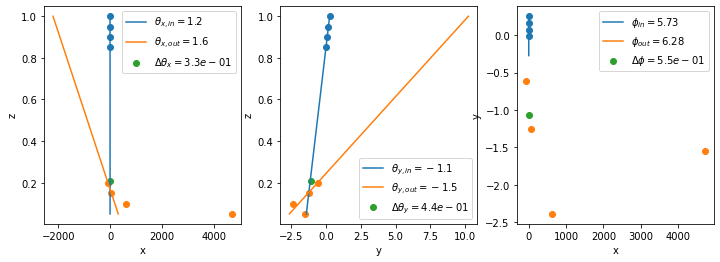

In [54]:
sb.plot_scatter(idx=3)

## X0 inference
From the scattering information, the next step is to use the information to infer the x0 of the passive volume. This is achieved by inverting the scattering equations to put them in terms of x0, however currently only the $\theta$ scattering formula has been inverted. N.B. the scattering formulas include random terms whose means of squares are one, however this relies on a sufficient number of muons **per voxel** in order to provide an accurate inference of x0. This, combined with the biased computation of $\delta\theta$ and the uncertainty due to resolution on scattering properties, means that x0 inference can be expected to be both inaccurate and imprecise.

To account for the fact that the inferred scatter location is uncertain and predictions of each muon carry different uncertainties, the x0 prediction of each muon goes into a weighted average for every voxel. The weights of each prediction per voxel account for the efficiency of the detectors the muon passed through, the uncertainty in the x0 prediction, and the probability of the scattering occurring in the given voxel according to the inferred scatter location and its uncertainty.

`tomopt.inference.volume.PanelX0Inferer` is used to compute predictions of the x0 composition of the passive volume from the `PanelScatterBatch` results.

In [55]:
from tomopt.inference import PanelX0Inferer

In [56]:
x0_inferer = PanelX0Inferer(volume=volume)

Currently the only inference method implemented is `x0_from_dtheta`. This computes the x0 predicted per muon, along with their uncertainties:

In [57]:
%%time
pred, pred_unc = x0_inferer.x0_from_dtheta(scatters=sb)

CPU times: user 40.7 ms, sys: 4.99 ms, total: 45.7 ms
Wall time: 30 ms


In [58]:
pred.shape

torch.Size([100])

In [59]:
pred[0], pred_unc[0]

(tensor(7.4722e-05, grad_fn=<SelectBackward0>),
 tensor(0.0260, grad_fn=<SelectBackward0>))

In [60]:
jacobian(pred_unc, volume.get_detectors()[0].panels[0].xy_span, create_graph=True).sum((-1))[:10]

tensor([ 7.8896e-06, -1.8188e-06, -4.3001e-03, -1.8534e-07, -9.1170e-03,
        -2.1158e-02, -3.3743e-03, -1.1917e+00, -2.1200e-03, -8.2200e-04],
       grad_fn=<SliceBackward0>)

The more general method `pred_x0` will call `x0_from_dtheta` and `x0_from dxy` (when implemented) and then compute a weighted average of the x0 predictions per voxel, returning a rank-3 tensor with the same number of elements as the passive volume. The weights used for per-muon ($i$) per voxel ($j$) predictions are:
$$w_{i,j} = \frac{\epsilon_i\times p_{i,j}}{\alpha_{x_{0,i}}^2},$$
where $\epsilon$ is the product of the efficiencies of the four hits associated with muon $i$, $\alpha_{x_{0,i}}$ is the uncertainty associated with prediction of muon $i$, and $p_{i,j}$ is the integral in x,y,z over voxel $j$ of a mulitivariate Gaussian (uncorrelated) centred at the scatter location of muon $i$ and widths equal to the uncertainty of the scatter location in x,y,z. Since these weights are also useful for constructing losses, the sum of weights per voxel is also returned.

`PanelX0Inferer` is set up to handle multiple batches of muon scatters. Adding the scatter batch to the inference will compute predictions based on the added batch:

In [61]:
x0_inferer.add_scatters(sb)

Muon-wise predictions are then stored in lists

In [62]:
x0_inferer.x0_dthetas, x0_inferer.x0_dtheta_uncs

([tensor([7.4722e-05, 4.1044e-03, 1.0811e-03, 2.7764e-05, 1.3807e-02, 4.5571e-03,
          1.0645e-03, 7.4207e-02, 6.2630e-03, 2.6179e-03, 3.6746e-03, 2.1692e-03,
          2.6871e-03, 4.4843e-03, 1.8862e-03, 9.3584e-02, 3.4898e-04, 8.1634e-03,
          2.4096e-02, 3.8264e-03, 1.1759e-03, 7.9544e-04, 3.5919e-01, 9.7345e-04,
          2.5724e-03, 3.1828e-03, 2.5369e-02, 1.8428e-02, 9.8214e-03, 6.9430e-03,
          3.7726e-02, 2.1692e-03, 1.6850e-03, 1.2632e-03, 2.7981e-03, 7.2208e-03,
          1.8640e-02, 3.3366e-03, 5.4076e-03, 1.1711e-02, 8.2113e-02, 3.7112e-03,
          1.1649e-02, 4.1389e-03, 2.9523e-02, 3.4845e-04, 1.7521e-02, 8.5251e-04,
          1.5016e-03, 1.6712e-03, 2.1108e-02, 3.2931e-03, 1.2762e-03, 3.0046e-04,
          1.7763e-04, 5.1025e-03, 1.9214e-06, 2.0632e-02, 1.4736e-03, 2.6882e-04,
          1.0913e-02, 8.0282e-03, 1.1854e-01, 1.9499e-03, 4.3417e-03, 1.8253e-03,
          4.9153e-05, 8.5981e-03, 1.1962e-02, 5.3913e-03, 6.9171e-03, 2.2176e-03,
          3.0362

As are volume-wise predicitons

In [63]:
x0_inferer.voxel_preds

[tensor([[[0.0013, 0.0011, 0.0009, 0.0010, 0.0040, 0.0048, 0.0044, 0.0039,
           0.0036, 0.0030],
          [0.0012, 0.0012, 0.0027, 0.0040, 0.0058, 0.0052, 0.0047, 0.0041,
           0.0036, 0.0028],
          [0.0013, 0.0014, 0.0059, 0.0051, 0.0062, 0.0058, 0.0051, 0.0043,
           0.0036, 0.0027],
          [0.0023, 0.0031, 0.0048, 0.0039, 0.0040, 0.0036, 0.0034, 0.0034,
           0.0034, 0.0033],
          [0.0030, 0.0031, 0.0030, 0.0026, 0.0027, 0.0026, 0.0026, 0.0027,
           0.0028, 0.0029],
          [0.0023, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0022, 0.0022,
           0.0022, 0.0022],
          [0.0030, 0.0036, 0.0030, 0.0028, 0.0033, 0.0023, 0.0021, 0.0022,
           0.0023, 0.0033],
          [0.0034, 0.0030, 0.0025, 0.0024, 0.0027, 0.0022, 0.0021, 0.0024,
           0.0025, 0.0035],
          [0.0038, 0.0026, 0.0023, 0.0023, 0.0027, 0.0013, 0.0013, 0.0025,
           0.0026, 0.0023],
          [0.0014, 0.0024, 0.0023, 0.0022, 0.0028, 0.0034, 0.0022, 0.0026

If we were to add multiple muon batches, then their combined volume-wise predictions can be averaged:

In [64]:
pred, weight = x0_inferer.get_prediction()

In [65]:
pred

tensor([[[0.0013, 0.0011, 0.0009, 0.0010, 0.0040, 0.0048, 0.0044, 0.0039,
          0.0036, 0.0030],
         [0.0012, 0.0012, 0.0027, 0.0040, 0.0058, 0.0052, 0.0047, 0.0041,
          0.0036, 0.0028],
         [0.0013, 0.0014, 0.0059, 0.0051, 0.0062, 0.0058, 0.0051, 0.0043,
          0.0036, 0.0027],
         [0.0023, 0.0031, 0.0048, 0.0039, 0.0040, 0.0036, 0.0034, 0.0034,
          0.0034, 0.0033],
         [0.0030, 0.0031, 0.0030, 0.0026, 0.0027, 0.0026, 0.0026, 0.0027,
          0.0028, 0.0029],
         [0.0023, 0.0024, 0.0024, 0.0023, 0.0023, 0.0023, 0.0022, 0.0022,
          0.0022, 0.0022],
         [0.0030, 0.0036, 0.0030, 0.0028, 0.0033, 0.0023, 0.0021, 0.0022,
          0.0023, 0.0033],
         [0.0034, 0.0030, 0.0025, 0.0024, 0.0027, 0.0022, 0.0021, 0.0024,
          0.0025, 0.0035],
         [0.0038, 0.0026, 0.0023, 0.0023, 0.0027, 0.0013, 0.0013, 0.0025,
          0.0026, 0.0023],
         [0.0014, 0.0024, 0.0023, 0.0022, 0.0028, 0.0034, 0.0022, 0.0026,
          0.0027,

## Loss
A range of loss classes are implemented in TomOpt: `tomopt.optimisation.loss.loss`. For this example we will are trying to predict the X0 of each voxel, so we will use the `VoxelX0Loss`. This consists of two components: The precision component based on the square error multiplied by the variance, averaged over the voxels $\left< \left(x_{0,\mathrm{pred}}-x_{0,\mathrm{true}}\right)^2 / w\right>$; And the budget cost of the whole detector timesed by a scaling coefficient. The budget cost is a function which is close to zero when the cost is below budget, and increases linearly when the cost is above budget. We initialise the loss by specifying the target budget (can set to `None` for no budget), the cost coefficient used to math the cost and error loss components (this can be set automatically by setting it to `None` and optionally using `tomopt.optimisation.callbacks.loss_callbacks.CostCoefWarmup`). For this tutorial, we'll set the target budget to `None` to swicth off the cost of the detector.

In [66]:
from tomopt.optimisation import VoxelX0Loss

In [67]:
loss_func = VoxelX0Loss(target_budget=None)

In [68]:
loss_val = loss_func(pred=pred, inv_pred_weight=weight, volume=volume)
loss_val

Automatically setting cost coefficient to 0.010196821764111519


tensor([0.0102], grad_fn=<AddBackward0>)

Let's backprop the loss and check that the detector parameters accumulate gradients:

In [69]:
volume.get_detectors()[0].panels[0].xy_span.grad, volume.get_detectors()[0].panels[0].xy.grad, volume.get_detectors()[0].panels[0].z.grad

(None, None, None)

In [70]:
loss_val.backward()

In [71]:
volume.get_detectors()[0].panels[0].xy_span.grad, volume.get_detectors()[0].panels[0].xy.grad, volume.get_detectors()[0].panels[0].z.grad

(tensor([-0.0077, -0.0407]), tensor([ 0.0072, -0.0259]), tensor([-0.1675]))

So generally increasing the span should decrease the loss (the optimal xyz position will depend on other panels and the passive volume).

## Optimiser
TomOpt uses the optimisers built into PyTorch, however due to the difference in scales for the parameters, we instead use three separate optimisers:

In [72]:
from torch import optim

In [73]:
xy_opt = optim.SGD((p.xy for l in volume.get_detectors() for p in l.panels), lr=1e0)
z_opt = optim.SGD((p.z for l in volume.get_detectors() for p in l.panels), lr=1e0)
xy_span_opt = optim.SGD((p.xy_span for l in volume.get_detectors() for p in l.panels), lr=1e0)

In [74]:
volume.get_detectors()[0].panels[0].xy_span, volume.get_detectors()[0].panels[0].xy, volume.get_detectors()[0].panels[0].z

(Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True),
 Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True),
 Parameter containing:
 tensor([1.], requires_grad=True))

In [75]:
xy_opt.step()
z_opt.step()
xy_span_opt.step()

In [76]:
volume.get_detectors()[0].panels[0].xy_span, volume.get_detectors()[0].panels[0].xy, volume.get_detectors()[0].panels[0].z

(Parameter containing:
 tensor([0.5077, 0.5407], requires_grad=True),
 Parameter containing:
 tensor([0.4928, 0.5259], requires_grad=True),
 Parameter containing:
 tensor([1.1675], requires_grad=True))

So the parameters shifted in the way that we expected from the gradients